In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv')
print(df.shape)
df.head()

(92016, 5)


,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
df["FullDate"] = pd.to_datetime(df["FullDate"]) #convert column to datetime
df.set_index("FullDate", inplace=True)
print(df.shape)
df.head()

(92016, 4)


,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
# Checking if there is are missing values

df.isnull().values.any()

False

### Question 11
Resample the data from an hour sampling rate to a daily sampling rate (i.e sum over the hours for each day). Which of the following is a plot of ElecPrice over time?

Text(0, 0.5, 'ElecPrice')

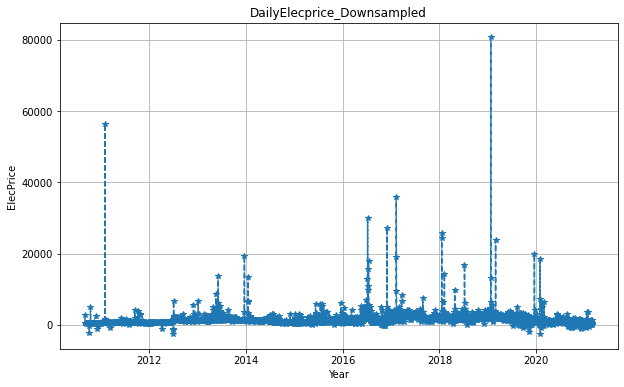

In [5]:
# Downsample to daily data points

df_daily = df.resample('D').sum()

plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.ElecPrice, '--', marker='*')
plt.grid()
plt.title('DailyElecprice_Downsampled')
plt.xlabel('Year')
plt.ylabel('ElecPrice')

###Question 12

Using the Augmented Dicky Fuller test (ADF), what is the P-value of the SysLoad and GasPrice of the resampled Data set, to 6 decimal places?

In [6]:
#Import adfuller
from statsmodels.tsa.stattools import adfuller 

adf_SysLoad = adfuller(df_daily['SysLoad'])
adf_GasPrice = adfuller(df_daily['GasPrice'])

print(f"P-value of SysLoad is {round(adf_SysLoad[1],6)}, while P-value of GasPrice is {round(adf_GasPrice[1],6)}")

P-value of SysLoad is 0.004254, while P-value of GasPrice is 0.045027


###Question 13

Using the Augmented Dicky Fuller test (ADF) what are the 10% and 5% critical values of GasPrice and ElecPrice of the resampled Data set, to 4 decimal places?

In [7]:
print('Critical values of GasPrice:')
for k, v in adf_GasPrice[4].items():
  print(f' {k} : {round(v, 4)}')

Critical values of GasPrice:
 1% : -3.4321
 5% : -2.8623
 10% : -2.5672


In [8]:
adf_ElecPrice = adfuller(df_daily['ElecPrice'])

print('Critical values of ElecPrice:')
for k, v in adf_ElecPrice[4].items():
  print(f' {k} : {round(v, 4)}')

Critical values of ElecPrice:
 1% : -3.4321
 5% : -2.8623
 10% : -2.5672


**The 10% and 5% critcal values of GasPrice and ElecPrice are `-2.5672` and `-2.8623` respectively** 

###Question 14
Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

Hint:

Define a function that calculates the Mape using the definition of MAPE from the course Module and pass your dataset into it.







In [9]:
# Rename the df_daily columns

data = df_daily.reset_index().rename(columns= {'FullDate':'ds', 'ElecPrice':'y'})

data.head()

,ds,Tmax,SysLoad,GasPrice,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [10]:
# Dividing the data into train  and test sets

train_data = data[0:2757]
test_data = data[2757:]

In [11]:
from prophet import Prophet

model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/a3c9_3jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/6pbox_fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62757', 'data', 'file=/tmp/tmpca9ds_rx/a3c9_3jk.json', 'init=/tmp/tmpca9ds_rx/6pbox_fk.json', 'output', 'file=/tmp/tmpiwrz1ti2/prophet_model-20221002235538.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:55:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
len(test_data)

1077

In [13]:
future = model.make_future_dataframe(periods=1077, freq='D')
forecast = model.predict(future)

In [14]:
# Calculating the MAPE

def mean_absolute_percentage_error(y_true, y_pred):
  return (np.mean(np.abs((y_true - y_pred) / y_true))) * 100
    
y_true = test_data['y'].values
y_pred = forecast['yhat'][2757:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE = {mape}')

MAPE = 539.22


### Question 15

What is the RMSE in 2 decimal places?

In [15]:
from sklearn.metrics import mean_squared_error

rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print(f'RMSE = {rmse}')

RMSE = 3196.64


### Question 16

If you plot the components from the forecasted model, what month of the yearly seasonality has the highest value?

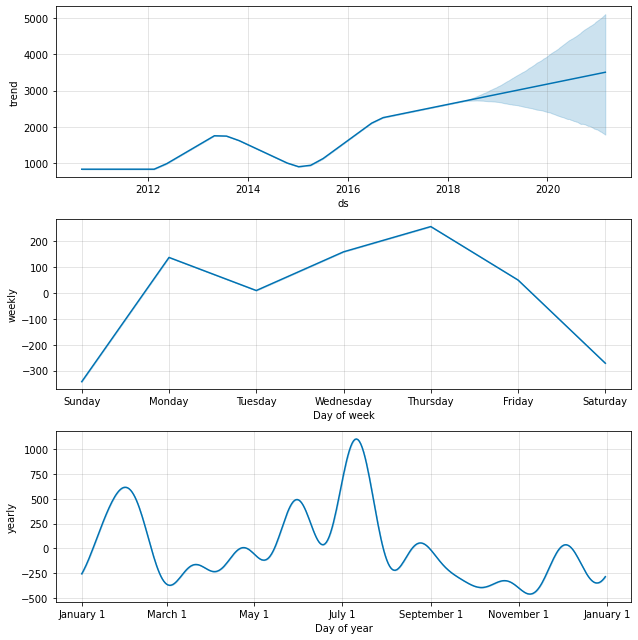

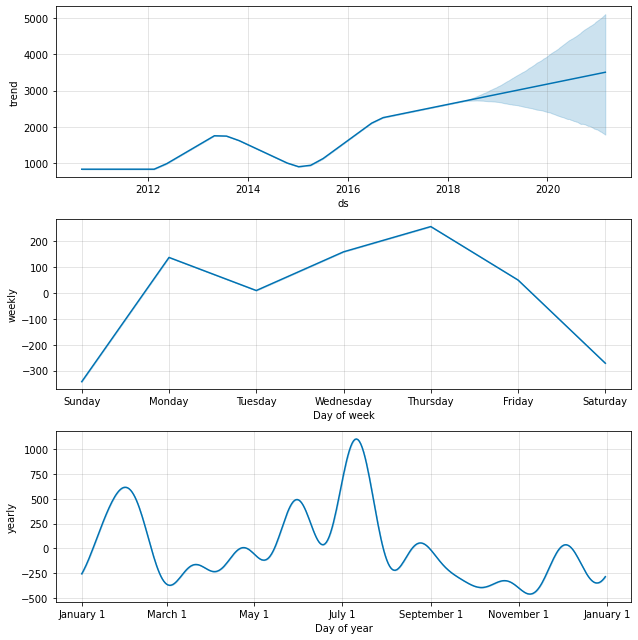

In [16]:
model.plot_components(forecast)

**Thursday has the highest value**



### Question 17

Evaluating the results of your time series model on the test set, what is the MAPE (in %) in 2 decimal places?

In [17]:
multivariate_data = df_daily.reset_index()[['FullDate','SysLoad','Tmax','GasPrice','ElecPrice']].rename(
    {'FullDate':'ds', 'SysLoad':'add1', 'Tmax':'add2', 'GasPrice':'add3', 'ElecPrice':'y'}, axis=1)

# split dataset

data_train = multivariate_data[0:2757]
data_test = multivariate_data[2757:]

In [18]:
model = Prophet()

#Adding regressors to the model

model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')

In [19]:
# Fit the data to the model
model.fit(data_train)


future = model.make_future_dataframe(periods=len(data_test), freq='D')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/kir9dik7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/edr72exn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97357', 'data', 'file=/tmp/tmpca9ds_rx/kir9dik7.json', 'init=/tmp/tmpca9ds_rx/edr72exn.json', 'output', 'file=/tmp/tmpobcyy9iq/prophet_model-20221002235556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [20]:
future['add1'] = multivariate_data['add1']
future['add2'] = multivariate_data['add2']
future['add3'] = multivariate_data['add3']
future

,ds,add1,add2,add3
0,2010-09-01,41565.38000,379.2,88.5600
1,2010-09-02,38898.99000,369.6,88.5600
2,2010-09-03,41665.76000,439.2,106.8000
3,2010-09-04,35638.08500,328.8,81.3600
4,2010-09-05,35611.41000,357.6,106.8000
...,...,...,...,...
3829,2021-02-24,-1525.49745,537.6,134.4000
3830,2021-02-25,4539.07855,518.4,130.5048
3831,2021-02-26,9517.02430,547.2,130.1808
3832,2021-02-27,4932.88015,564.0,130.0800


In [22]:
# forecasting

forecast = model.predict(future)

In [23]:
# Calulating MAPE

y_true = data_test['y'].values
y_pred = forecast['yhat'][2757:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE = {mape}')

MAPE = 232.43


### Question 18

What is the RMSE in 2 decimal places?

In [24]:
# Calculating RMSE 

rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
print(f'RMSE of Multivariate model: {rmse}')

RMSE of Multivariate model: 2708.17


### Question 19

If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the highest value?

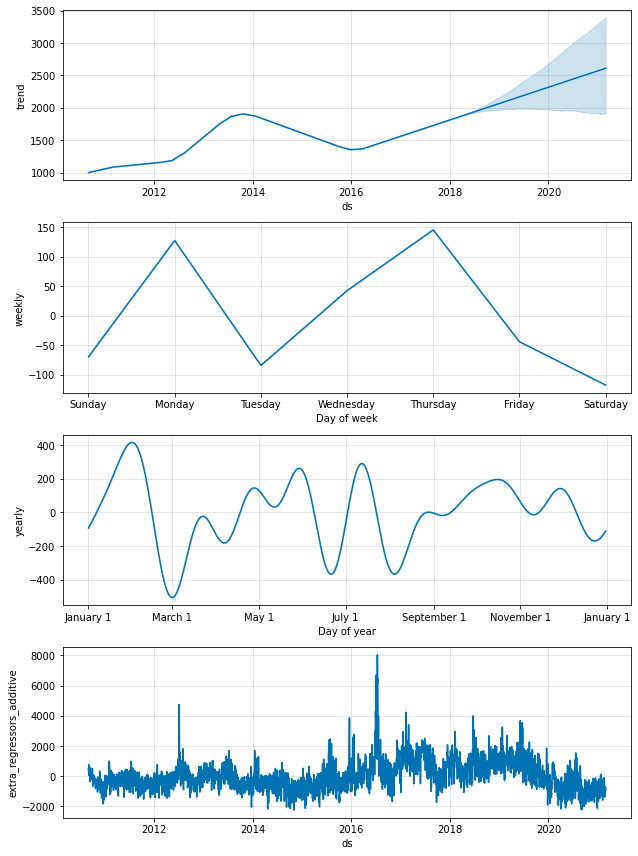

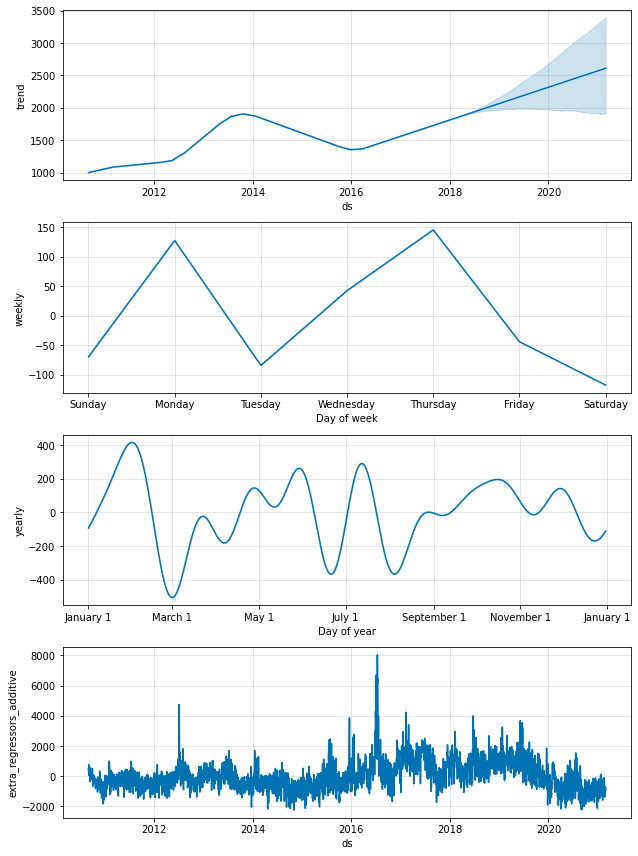

In [25]:
model.plot_components(forecast)

**Thursday has the highest value**

### Question 20

Train a multivariate time series model performing the same train test split as before, but now exclude T-max from the training data(drop T-max),

What is the mean absolute percentage error (MAPE) to 2 decimal places on the test set?

In [26]:
data_train = data_train.drop(['add2'], axis=1)

model = Prophet()

model.add_regressor('add1')
model.add_regressor('add3')

model.fit(data_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/7qveh0it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca9ds_rx/kxe7ri1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37301', 'data', 'file=/tmp/tmpca9ds_rx/7qveh0it.json', 'init=/tmp/tmpca9ds_rx/kxe7ri1f.json', 'output', 'file=/tmp/tmpw7koltmw/prophet_model-20221002235944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
future = model.make_future_dataframe(periods=len(data_test), freq='D')

multivariate_data = df_daily.reset_index()[['FullDate','SysLoad','GasPrice','ElecPrice']].rename(
    {'FullDate':'ds', 'SysLoad':'add1', 'GasPrice':'add3', 'ElecPrice':'y'}, axis=1)


In [28]:
future['add1'] = multivariate_data['add1']
future['add3'] = multivariate_data['add3']

forecast = model.predict(future)

In [29]:
y_true = data_test['y'].values
y_pred = forecast['yhat'][2757:].values

mape = round(mean_absolute_percentage_error(y_true, y_pred), 2)
print(f'MAPE = {mape}')

MAPE = 232.38
